In [1]:
!pip install pycocotools
!pip install torchsummary
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 11.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=4871ca73ab26adc3575ac63cb202950c86d249f8e9da863bb5464c8c4b0e4104
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pycocotools.coco import COCO
import torchvision.transforms as T
import torchvision.transforms as transforms
from torchsummary import summary
import math
from tqdm import tqdm

In [3]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Initialize COCO data

In [6]:
# Paths to annotation files
coco_train_inst_ann_file = "/kaggle/input/deepl-project/instances_train2017.json"
coco_train_caps_ann_file = "/kaggle/input/deepl-project/captions_train2017.json"
coco_val_inst_ann_file = "/kaggle/input/deepl-project/instances_val2017.json"
coco_val_caps_ann_file = "/kaggle/input/deepl-project/captions_val2017.json"

# path to filtered images
# train_img_dir = '/kaggle/input/deepl-project/imgs_filtered_train/imgs_filtered'
# val_img_dir = '/kaggle/input/deepl-project/imgs_filtered_val/imgs_filtered'

#path to all images
train_img_dir_all = '/kaggle/input/deepl-project/resized_35000/imgs'
val_img_dir_all = '/kaggle/input/deepl-project/all_imgs_val/imgs'

# Initialize COCO objects
coco_train = COCO(coco_train_inst_ann_file)
coco_train_caps = COCO(coco_train_caps_ann_file)
coco_val = COCO(coco_val_inst_ann_file)
coco_val_caps = COCO(coco_val_caps_ann_file)

loading annotations into memory...
Done (t=21.93s)
creating index...
index created!
loading annotations into memory...
Done (t=2.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [7]:
# Define augmentations
augmentations = T.Compose([
    T.RandomHorizontalFlip(p=0.5),  # randomly flip horizontally with 50% probability
    T.RandomRotation(10, expand=False),  # randomly rotate by 10 degrees without cropping
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # random affine transformations
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Define transformation for training data
train_transform = T.Compose([
    augmentations,
    T.ToTensor(),  # transform to tensor, brings pixels to range (0, 1)
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # normalize to range (-1, 1) for all three channels
])

# Define transformation for validation data, no augmentations needed
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

#### Create data class for COCO data set

In [8]:
class CocoCountDataset(Dataset):
    def __init__(self, img_dir, coco, coco_caps, img_ids, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.coco = coco
        self.coco_caps = coco_caps
        self.transform = transform

        # limit number of samples for testing purposes
        if max_samples:
            self.img_ids = img_ids[:max_samples]
        else:
            self.img_ids = img_ids

        if not self.img_ids:
            raise ValueError("No valid images found after filtering non-existing files.")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.coco.getCatIds(catNms=['person']), iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        count = len(anns)  # Number of people in the image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)

In [9]:
# Define max_samples
# max_samples = 2000

# Map id to downloaded images
downloaded_train_imgs = set(os.listdir(train_img_dir_all))
downloaded_val_imgs = set(os.listdir(val_img_dir_all))

train_img_ids = []
for img_info in coco_train.dataset['images']:
    if img_info['file_name'] in downloaded_train_imgs:
        train_img_ids.append(img_info['id'])
        
val_img_ids = []
for img_info in coco_val.dataset['images']:
    if img_info['file_name'] in downloaded_val_imgs:
        val_img_ids.append(img_info['id'])

# Create test split from training set
coco_train_ids, coco_test_ids = train_test_split(train_img_ids, test_size=0.2, random_state=42)
        
# Create data sets
try:
    coco_train_dataset = CocoCountDataset(
        img_dir=train_img_dir_all,
        coco=coco_train,
        coco_caps=coco_train_caps,
        img_ids=coco_train_ids,
        transform=train_transform,
        # max_samples=max_samples
    )
    print(f"Number of training images: {len(coco_train_dataset)}")

    coco_val_dataset = CocoCountDataset(
        img_dir=val_img_dir_all,
        coco=coco_val,
        coco_caps=coco_val_caps,
        img_ids=val_img_ids,
        transform=val_transform,
        # max_samples=max_samples 
    )
    print(f"Number of validation images: {len(coco_val_dataset)}")
    
    # COCO test set (from split)
    coco_test_dataset = CocoCountDataset(
        img_dir=train_img_dir_all,
        coco=coco_train,
        coco_caps=coco_train_caps,
        img_ids=coco_test_ids,
        transform=val_transform
    )
    print(f"Number of test images: {len(coco_test_dataset)}")

except ValueError as e:
    print(e)

Number of training images: 15140
Number of validation images: 1303
Number of test images: 3785


#### Create data class for oxford town data set

In [10]:
oxford_annotations = pd.read_csv('/kaggle/input/deepl-project/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])

data = oxford_annotations.drop(['headNumber','personNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'bodyLeft',
                  'bodyTop','bodyRight','bodyBottom','headBottom'], axis='columns')

count_data = data.drop_duplicates(subset='frameNumber', keep='first')

frame_counts = data['frameNumber'].value_counts(sort = False).reset_index()
frame_counts.columns = ['frameNumber', 'count']

count_data = count_data.merge(frame_counts, on='frameNumber')

# Train-val-test split
ox_train_counts, ox_val_test_counts = train_test_split(count_data, test_size=0.4, random_state=42)  # 60% train, 40% val+test
ox_val_counts, ox_test_counts = train_test_split(ox_val_test_counts, test_size=0.5, random_state=42)  # 20% val, 20% test

In [11]:
class oxfordDataset(Dataset):
    def __init__(self, data_dir, frame_counts, transform=None, exclude_frame=None):
        self.data_dir = data_dir
        self.data = frame_counts
        self.transform = transform
        self.exclude_frame = exclude_frame  # Frame number to exclude (img is damaged)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_info = self.data.iloc[idx]
        img_filename = f"{img_info['frameNumber']}.jpg" 

        # Skip damaged image
        if self.exclude_frame is not None and img_info['frameNumber'] == self.exclude_frame:
            return self.__getitem__((idx + 1) % len(self.data))

        img_path = os.path.join(self.data_dir, img_filename)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError):
            return self.__getitem__((idx + 1) % len(self.data))  # Skip if file is not found or is damaged

        count = img_info['count']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)


In [12]:
# Create train, validation and test datasets

ox_img = "/kaggle/input/deepl-project/imgs_filtered-20240731T120956Z-001/imgs_filtered"

ox_train_dataset = oxfordDataset(
    data_dir=ox_img,
    frame_counts=ox_train_counts,
    transform=train_transform,
    exclude_frame=1134
)

ox_val_dataset = oxfordDataset(
    data_dir=ox_img,
    frame_counts=ox_val_counts,
    transform=val_transform,
    exclude_frame=1134
)

ox_test_dataset = oxfordDataset(
    data_dir=ox_img,
    frame_counts=ox_test_counts,
    transform=val_transform,
    exclude_frame=1134
)

#### Combine data sets and create data loaders for model

In [13]:
# Use torch concat dataset to combine the datasets

train_combined_dataset = ConcatDataset([coco_train_dataset, ox_train_dataset])
val_combined_dataset = ConcatDataset([coco_val_dataset, ox_val_dataset])
test_combined_dataset = ConcatDataset([coco_test_dataset, ox_test_dataset])

# Create data loaders
train_loader = DataLoader(train_combined_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_combined_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_combined_dataset, batch_size=16, shuffle=False, num_workers=4)

test_loader_ox = DataLoader(ox_test_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader_coco = DataLoader(coco_test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [14]:
# Check the lengths of individual and combined datasets to ensure that the concatenation was successful
print(f"Length of COCO train dataset: {len(coco_train_dataset)}")
print(f"Length of Oxford train dataset: {len(ox_train_dataset)}")
print(f"Length of Combined train dataset: {len(train_combined_dataset)}")

Length of COCO train dataset: 15140
Length of Oxford train dataset: 1854
Length of Combined train dataset: 16994


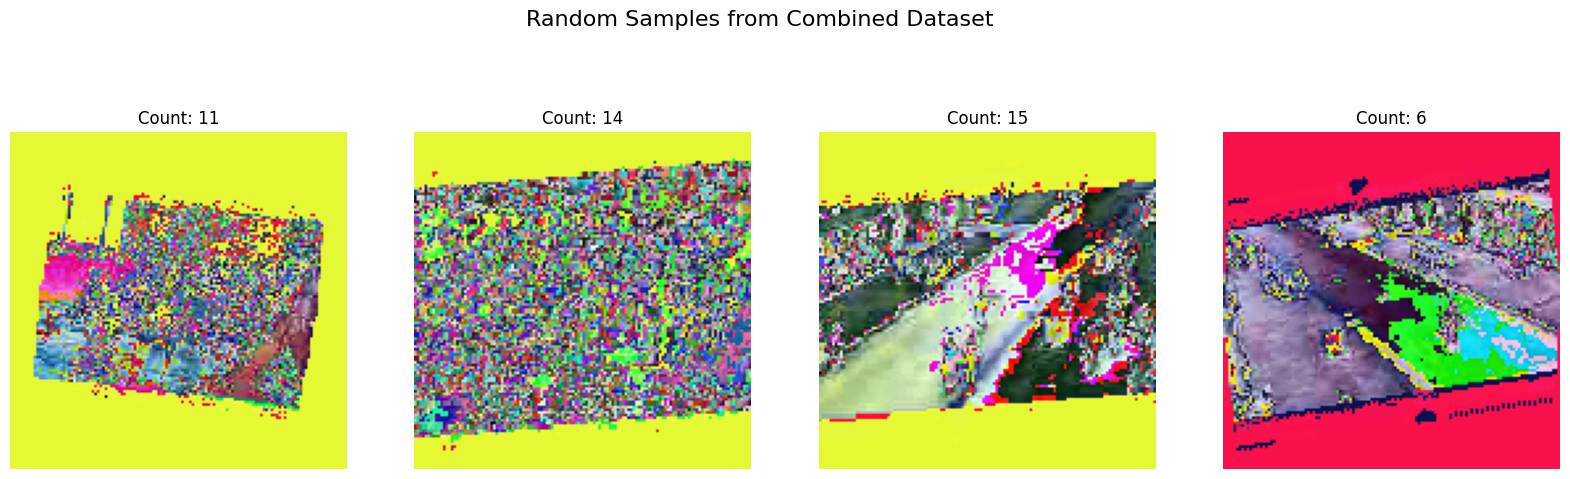

In [15]:
# Visualize random images from combined data set

def visualize_random_samples(dataset, num_samples=5):

    # Get random indices
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 6))
    fig.suptitle('Random Samples from Combined Dataset', fontsize=16)

    for i, idx in enumerate(indices):
        img, count = dataset[idx]
        # Convert tensor to PIL image for visualization
        img = T.ToPILImage()(img)
        # Plot image
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Count: {int(count.item())}')

    plt.show()

visualize_random_samples(train_combined_dataset, num_samples=4)

#### Define model

In [15]:
# Define early stopping class

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [16]:
# Define model architecture

# Basic block with two convolutional layers
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Overall CNN model architecture
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Stacked layers of basic block with increasing number of filters
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize model and define number of blocks for each layer
# cnn_model = CNN(BasicBlock, [2, 2, 2, 2]).to(device)
cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)
summary(cnn_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           4,608
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           4,608
       BatchNorm2d-8         [-1, 32, 128, 128]              64
              ReLU-9         [-1, 32, 128, 128]               0
       BasicBlock-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 16, 128, 128]           4,608
      BatchNorm2d-12         [-1, 16, 128, 128]              32
             ReLU-13         [-1, 16, 128, 128]               0
           Conv2d-14         [-1, 32, 1

In [17]:
# Define training function

def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):#, max_norm=1.0):
    train_losses = []
    val_losses = []
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    for epoch in range(epochs):
        model.train() # Set model to training mode
        train_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1)  # Reshape target to match output shape

                optimizer.zero_grad() # reset gradients
                output = model(data)  # Get model output
                loss = criterion(output, target) # Calculate loss
                loss.backward() # Backpropagate loss
                
                # Gradient clipping
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                
                optimizer.step() # Update weights
                train_loss += loss.item() # Accumulate loss
                pbar.update(1)

        train_losses.append(train_loss / len(train_loader)) # average training loss for the epoch

        model.eval() # Set to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1) 
                output = model(data)  
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')
        
        scheduler.step(val_loss) # Adjust learning rate based on validation loss
        
        # Check for early stopping and save best model
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

Epoch 1/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.52batch/s]


Epoch: 1, Training Loss: 21.8774, Validation Loss: 24.2710

Validation loss decreased (24.271017 --> 24.271017).  Saving model ...


Epoch 2/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.51batch/s]


Epoch: 2, Training Loss: 17.9360, Validation Loss: 27.6736


Epoch 3/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.51batch/s]


Epoch: 3, Training Loss: 15.8694, Validation Loss: 25.3703


Epoch 4/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.73batch/s]


Epoch: 4, Training Loss: 14.4897, Validation Loss: 21.5187

Validation loss decreased (24.271017 --> 21.518671).  Saving model ...


Epoch 5/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.61batch/s]


Epoch: 5, Training Loss: 13.5978, Validation Loss: 17.6048

Validation loss decreased (21.518671 --> 17.604777).  Saving model ...


Epoch 6/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.59batch/s]


Epoch: 6, Training Loss: 13.0765, Validation Loss: 14.3743

Validation loss decreased (17.604777 --> 14.374280).  Saving model ...


Epoch 7/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.50batch/s]


Epoch: 7, Training Loss: 12.7002, Validation Loss: 25.1667


Epoch 8/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.43batch/s]


Epoch: 8, Training Loss: 12.0944, Validation Loss: 12.0657

Validation loss decreased (14.374280 --> 12.065719).  Saving model ...


Epoch 9/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.63batch/s]


Epoch: 9, Training Loss: 11.9191, Validation Loss: 13.7413


Epoch 10/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.60batch/s]


Epoch: 10, Training Loss: 11.4314, Validation Loss: 14.9851


Epoch 11/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.64batch/s]


Epoch: 11, Training Loss: 11.2402, Validation Loss: 12.8045


Epoch 12/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.74batch/s]


Epoch: 12, Training Loss: 10.9978, Validation Loss: 13.5760


Epoch 13/100: 100%|██████████| 1063/1063 [01:09<00:00, 15.35batch/s]


Epoch: 13, Training Loss: 10.8759, Validation Loss: 13.2889


Epoch 14/100: 100%|██████████| 1063/1063 [01:09<00:00, 15.27batch/s]


Epoch: 14, Training Loss: 10.6816, Validation Loss: 14.8770

Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.


Epoch 15/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.44batch/s]


Epoch: 15, Training Loss: 9.8802, Validation Loss: 10.8557

Validation loss decreased (12.065719 --> 10.855740).  Saving model ...


Epoch 16/100: 100%|██████████| 1063/1063 [01:10<00:00, 15.10batch/s]


Epoch: 16, Training Loss: 9.7946, Validation Loss: 10.1209

Validation loss decreased (10.855740 --> 10.120892).  Saving model ...


Epoch 17/100: 100%|██████████| 1063/1063 [01:09<00:00, 15.31batch/s]


Epoch: 17, Training Loss: 9.6026, Validation Loss: 12.0492


Epoch 18/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.60batch/s]


Epoch: 18, Training Loss: 9.4048, Validation Loss: 11.6218


Epoch 19/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.71batch/s]


Epoch: 19, Training Loss: 9.3401, Validation Loss: 10.1257


Epoch 20/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.73batch/s]


Epoch: 20, Training Loss: 9.3171, Validation Loss: 9.9215

Validation loss decreased (10.120892 --> 9.921481).  Saving model ...


Epoch 21/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.60batch/s]


Epoch: 21, Training Loss: 9.2536, Validation Loss: 13.2584


Epoch 22/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.62batch/s]


Epoch: 22, Training Loss: 9.0216, Validation Loss: 9.3367

Validation loss decreased (9.921481 --> 9.336743).  Saving model ...


Epoch 23/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.65batch/s]


Epoch: 23, Training Loss: 8.9868, Validation Loss: 13.4754


Epoch 24/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.66batch/s]


Epoch: 24, Training Loss: 8.9499, Validation Loss: 10.2372


Epoch 25/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.62batch/s]


Epoch: 25, Training Loss: 8.8022, Validation Loss: 9.5711


Epoch 26/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.69batch/s]


Epoch: 26, Training Loss: 8.7104, Validation Loss: 10.7586


Epoch 27/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.60batch/s]


Epoch: 27, Training Loss: 8.6814, Validation Loss: 9.2284

Validation loss decreased (9.336743 --> 9.228386).  Saving model ...


Epoch 28/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.71batch/s]


Epoch: 28, Training Loss: 8.6434, Validation Loss: 9.0400

Validation loss decreased (9.228386 --> 9.039970).  Saving model ...


Epoch 29/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.65batch/s]


Epoch: 29, Training Loss: 8.4988, Validation Loss: 9.2712


Epoch 30/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.41batch/s]


Epoch: 30, Training Loss: 8.5975, Validation Loss: 12.2985


Epoch 31/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.51batch/s]


Epoch: 31, Training Loss: 8.3142, Validation Loss: 9.8771


Epoch 32/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.47batch/s]


Epoch: 32, Training Loss: 8.2617, Validation Loss: 10.4733


Epoch 33/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.48batch/s]


Epoch: 33, Training Loss: 8.3154, Validation Loss: 11.5070


Epoch 34/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.47batch/s]


Epoch: 34, Training Loss: 8.2571, Validation Loss: 9.8745

Epoch 00034: reducing learning rate of group 0 to 2.5000e-05.


Epoch 35/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.46batch/s]


Epoch: 35, Training Loss: 7.6876, Validation Loss: 8.8228

Validation loss decreased (9.039970 --> 8.822827).  Saving model ...


Epoch 36/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.69batch/s]


Epoch: 36, Training Loss: 7.6011, Validation Loss: 8.9485


Epoch 37/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.79batch/s]


Epoch: 37, Training Loss: 7.6390, Validation Loss: 9.4041


Epoch 38/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.72batch/s]


Epoch: 38, Training Loss: 7.6665, Validation Loss: 9.0884


Epoch 39/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.76batch/s]


Epoch: 39, Training Loss: 7.4663, Validation Loss: 9.4835


Epoch 40/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.89batch/s]


Epoch: 40, Training Loss: 7.3891, Validation Loss: 9.4125


Epoch 41/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.77batch/s]


Epoch: 41, Training Loss: 7.3301, Validation Loss: 9.0248

Epoch 00041: reducing learning rate of group 0 to 1.2500e-05.


Epoch 42/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.70batch/s]


Epoch: 42, Training Loss: 7.0819, Validation Loss: 8.7606

Validation loss decreased (8.822827 --> 8.760578).  Saving model ...


Epoch 43/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.57batch/s]


Epoch: 43, Training Loss: 7.0470, Validation Loss: 8.5289

Validation loss decreased (8.760578 --> 8.528871).  Saving model ...


Epoch 44/100: 100%|██████████| 1063/1063 [01:09<00:00, 15.34batch/s]


Epoch: 44, Training Loss: 7.0211, Validation Loss: 8.7913


Epoch 45/100: 100%|██████████| 1063/1063 [01:09<00:00, 15.39batch/s]


Epoch: 45, Training Loss: 6.9746, Validation Loss: 8.8892


Epoch 46/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.66batch/s]


Epoch: 46, Training Loss: 6.9673, Validation Loss: 8.5075

Validation loss decreased (8.528871 --> 8.507543).  Saving model ...


Epoch 47/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.70batch/s]


Epoch: 47, Training Loss: 6.9493, Validation Loss: 8.4753

Validation loss decreased (8.507543 --> 8.475258).  Saving model ...


Epoch 48/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.76batch/s]


Epoch: 48, Training Loss: 6.9801, Validation Loss: 8.7564


Epoch 49/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.71batch/s]


Epoch: 49, Training Loss: 6.9381, Validation Loss: 8.2231

Validation loss decreased (8.475258 --> 8.223133).  Saving model ...


Epoch 50/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.74batch/s]


Epoch: 50, Training Loss: 6.8820, Validation Loss: 8.5770


Epoch 51/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.66batch/s]


Epoch: 51, Training Loss: 6.8003, Validation Loss: 8.4584


Epoch 52/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.59batch/s]


Epoch: 52, Training Loss: 6.8847, Validation Loss: 8.8037


Epoch 53/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.81batch/s]


Epoch: 53, Training Loss: 6.7447, Validation Loss: 8.8811


Epoch 54/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.84batch/s]


Epoch: 54, Training Loss: 6.8064, Validation Loss: 8.4586


Epoch 55/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.85batch/s]


Epoch: 55, Training Loss: 6.7665, Validation Loss: 8.7939

Epoch 00055: reducing learning rate of group 0 to 6.2500e-06.


Epoch 56/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.71batch/s]


Epoch: 56, Training Loss: 6.5090, Validation Loss: 8.6082


Epoch 57/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.58batch/s]


Epoch: 57, Training Loss: 6.5179, Validation Loss: 8.6238


Epoch 58/100: 100%|██████████| 1063/1063 [01:08<00:00, 15.62batch/s]


Epoch: 58, Training Loss: 6.5663, Validation Loss: 8.4978


Epoch 59/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.81batch/s]


Epoch: 59, Training Loss: 6.5546, Validation Loss: 8.6590


Epoch 60/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.94batch/s]


Epoch: 60, Training Loss: 6.3640, Validation Loss: 8.4338


Epoch 61/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.89batch/s]


Epoch: 61, Training Loss: 6.5147, Validation Loss: 9.1997

Epoch 00061: reducing learning rate of group 0 to 3.1250e-06.


Epoch 62/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.84batch/s]


Epoch: 62, Training Loss: 6.2967, Validation Loss: 8.3611


Epoch 63/100: 100%|██████████| 1063/1063 [01:07<00:00, 15.83batch/s]


Epoch: 63, Training Loss: 6.4334, Validation Loss: 8.6213


Epoch 64/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.97batch/s]


Epoch: 64, Training Loss: 6.3978, Validation Loss: 8.7189


Epoch 65/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.92batch/s]


Epoch: 65, Training Loss: 6.2355, Validation Loss: 8.5521


Epoch 66/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.97batch/s]


Epoch: 66, Training Loss: 6.3571, Validation Loss: 8.4913


Epoch 67/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.95batch/s]


Epoch: 67, Training Loss: 6.2836, Validation Loss: 8.5025

Epoch 00067: reducing learning rate of group 0 to 1.5625e-06.


Epoch 68/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.95batch/s]


Epoch: 68, Training Loss: 6.3258, Validation Loss: 8.4330


Epoch 69/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.90batch/s]


Epoch: 69, Training Loss: 6.3201, Validation Loss: 8.5564


Epoch 70/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.94batch/s]


Epoch: 70, Training Loss: 6.2064, Validation Loss: 8.7164


Epoch 71/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.99batch/s]


Epoch: 71, Training Loss: 6.2751, Validation Loss: 8.5390


Epoch 72/100: 100%|██████████| 1063/1063 [01:06<00:00, 16.03batch/s]


Epoch: 72, Training Loss: 6.1664, Validation Loss: 8.4698


Epoch 73/100: 100%|██████████| 1063/1063 [01:05<00:00, 16.12batch/s]


Epoch: 73, Training Loss: 6.2430, Validation Loss: 8.5157

Epoch 00073: reducing learning rate of group 0 to 7.8125e-07.


Epoch 74/100: 100%|██████████| 1063/1063 [01:06<00:00, 15.94batch/s]


Epoch: 74, Training Loss: 6.2058, Validation Loss: 8.5813

Early stopping triggered.


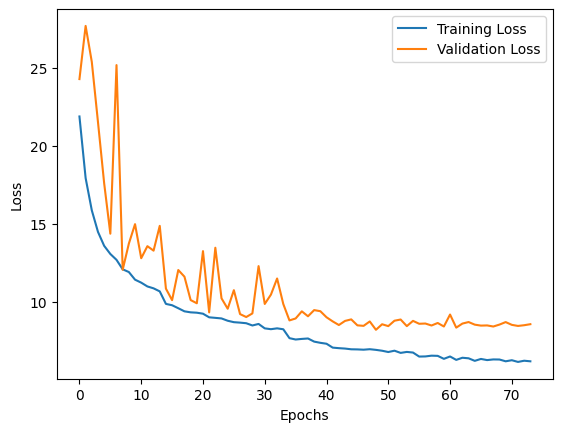

In [22]:
# set hyperparameters
epochs = 100
patience = 25
lr = 0.0001
reg = 0.0001

criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=reg) # Initialize Adam optimizer
early_stopper = EarlyStopping(patience=patience)

# training the model
# train_losses, val_losses = train_cnn_model(epochs, cnn_model, cnn_optimizer, criterion, train_loader, val_loader, early_stopper)

# plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Save model and reload
# torch.save(cnn_model.state_dict(), "cnn_model_weights.pth")

cnn_model.load_state_dict(torch.load("/kaggle/input/deepl-project/cnn_model_weights.pth"))

<All keys matched successfully>

In [19]:
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, count in data_loader:
            images, count = images.to(device), count.to(device)
            output = model(images)
            y_preds.extend(output.cpu().numpy())
            y_true.extend(count.cpu().numpy())

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_preds)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return mae, mse, rmse, r2

evaluate_model(test_loader, cnn_model)

Mean Absolute Error (MAE): 1.7972
Mean Squared Error (MSE): 7.3055
Root Mean Squared Error (RMSE): 2.7029
R-squared (R2): 0.7877


(1.7972325, 7.3054514, 2.7028599, 0.787716008955631)

In [21]:
# Evaluate Oxford and COCO data set separately
print("Evaluation Oxford town images")
evaluate_model(test_loader_ox, cnn_model)
print("------------------------------")
print("Evaluation COCO images")
evaluate_model(test_loader_coco, cnn_model)

Evaluation Oxford town images
Mean Absolute Error (MAE): 0.7363
Mean Squared Error (MSE): 1.0714
Root Mean Squared Error (RMSE): 1.0351
R-squared (R2): 0.9575
------------------------------
Evaluation COCO images
Mean Absolute Error (MAE): 1.9707
Mean Squared Error (MSE): 8.3250
Root Mean Squared Error (RMSE): 2.8853
R-squared (R2): 0.5171


(1.9707366, 8.324972, 2.8853028, 0.5171309254114731)

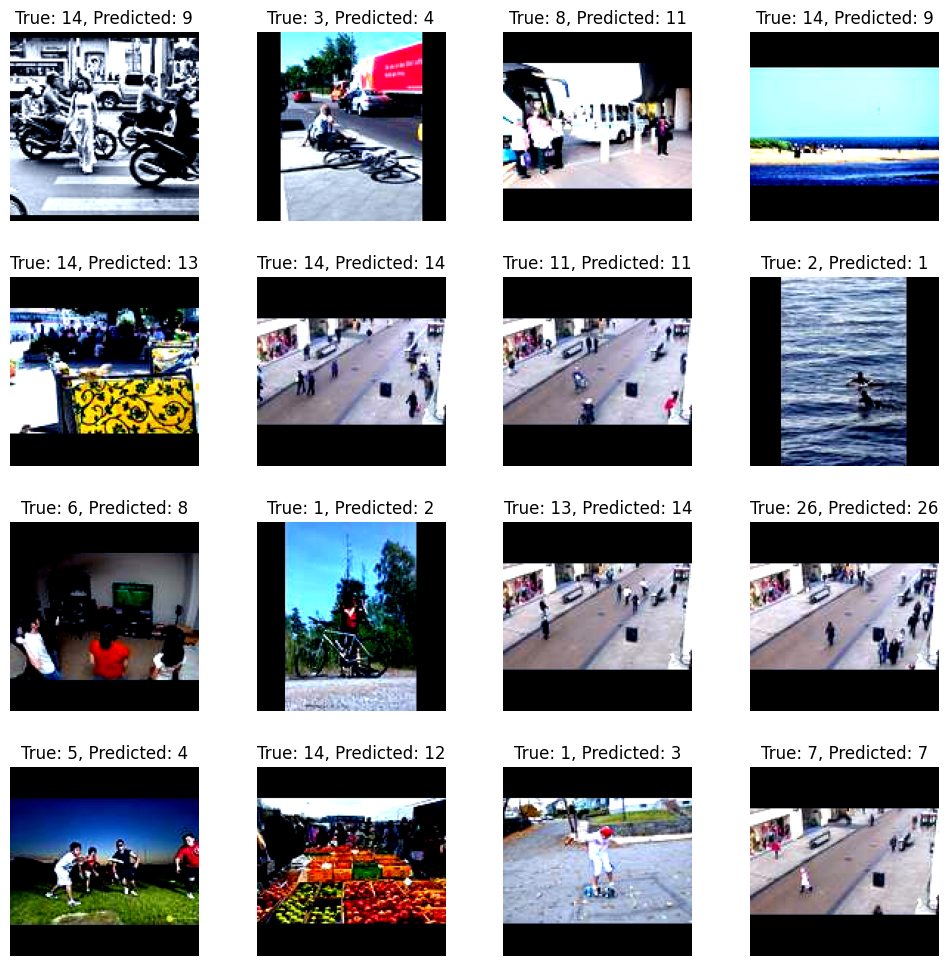

In [25]:
# Visualize prediction for a random sample of images

def visualize_prediction(model, dataset, number_of_images):
    model.eval()

    random_indices = random.sample(range(len(dataset)), number_of_images)

    # Calculate grid size
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))  # Adjust figure size based on rows
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, idx in enumerate(random_indices):
        image, true_count = dataset[idx]
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            predicted_count = model(image_tensor) 
            predicted_count = torch.round(predicted_count).item() 
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = image_np * 0.5 + 0.5

            if rows == 1 and cols == 1:
                ax = axes
            elif rows == 1 or cols == 1:
                ax = axes[i]
            else:
                ax = axes[i // cols, i % cols]

            ax.imshow(image_np)
            ax.set_title(f"True: {int(true_count)}, Predicted: {int(predicted_count)}")
            ax.axis('off')

    plt.show()

visualize_prediction(cnn_model, val_combined_dataset, number_of_images=16)

In [26]:
# Visualize model architecture

from torchviz import make_dot

dummy_input = torch.randn(1, 3, 128, 128).to(device)
output = cnn_model(dummy_input)
model_graph = make_dot(output, params=dict(cnn_model.named_parameters()))
model_graph.render("cnn_model_graph", format="png")  # Saves the graph as a PNG file

'cnn_model_graph.png'